In [1]:
# 1. Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Recall
from scipy.special import expit
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score 

import numpy as np
warnings.filterwarnings("ignore")


In [2]:
# 2. Cargar tu dataset
data = pd.read_excel('./Data/Resultados/segmentacion_responde_v4.xlsx')
data.head()

,ID_Cliente,Importe_total_seg,Ticket_medio_seg,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
0,C100004,130.43,32.6075,4,711,2023,6,6,1,0,...,0,0.125,0.000000,0.214286,0.000000,0.487320,0.0,0.088533,0.365483,0
1,C100005,196.48,98.2400,2,110,2024,3,6,2,0,...,3,0.175,0.027071,0.071429,0.013865,0.075394,0.2,0.021968,0.353844,1
2,C100006,497.88,99.5760,5,254,2024,3,2,3,0,...,0,0.125,0.011930,0.285714,0.004074,0.174092,0.0,0.259362,0.395136,1
3,C100012,423.60,70.6000,6,200,2024,5,4,5,0,...,1,0.275,0.015026,0.357143,0.003078,0.137080,0.6,0.712109,0.769607,1
4,C100019,120.13,60.0650,2,634,2023,6,6,1,0,...,0,0.125,0.000000,0.071429,0.000000,0.434544,0.0,-0.172038,0.319967,0


In [3]:
df_sim = data[data['Año'] == 2024].copy()
df_sim

,ID_Cliente,Importe_total_seg,Ticket_medio_seg,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
1,C100005,196.48,98.240000,2,110,2024,3,6,2,0,...,3,0.175,0.027071,0.071429,0.013865,0.075394,0.2,0.021968,0.353844,1
2,C100006,497.88,99.576000,5,254,2024,3,2,3,0,...,0,0.125,0.011930,0.285714,0.004074,0.174092,0.0,0.259362,0.395136,1
3,C100012,423.60,70.600000,6,200,2024,5,4,5,0,...,1,0.275,0.015026,0.357143,0.003078,0.137080,0.6,0.712109,0.769607,1
5,C100025,59.16,29.580000,2,81,2024,1,1,2,0,...,2,0.225,0.003148,0.071429,0.001612,0.055517,0.4,0.042547,0.357445,0
7,C100030,329.46,82.365000,4,112,2024,6,1,2,1,...,2,0.225,0.004331,0.214286,0.001109,0.076765,0.4,0.393948,0.418063,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131219,C999965,670.29,83.786250,8,19,2024,6,7,5,1,...,1,0.275,0.018899,0.500000,0.004840,0.013023,0.6,0.128477,0.672453,0
131220,C999966,297.22,148.610000,2,77,2024,3,3,1,1,...,3,0.175,0.024677,0.071429,0.012639,0.052776,0.2,-0.314775,0.295365,1
131221,C999974,229.99,57.497500,4,189,2024,5,2,3,0,...,0,0.125,0.030247,0.214286,0.006197,0.129541,0.0,-0.059644,0.339565,0
131222,C999976,587.35,146.837500,4,103,2024,3,7,3,0,...,2,0.225,0.021788,0.214286,0.007439,0.070596,0.4,-0.070695,0.337633,1


In [184]:
df_sim.columns

Index(['ID_Cliente', 'Importe_total_seg', 'Ticket_medio_seg', 'Frecuencia',
       'Dias_desde_ultima_factura', 'Año', 'Categoria_top',
       'Categoria_menos_frecuente', 'Categorias_distintas', 'Canal_preferido',
       'Edad', 'Metodo_pago', 'Genero', 'Importe_total', 'Ticket_medio',
       'Cluster_Economico', 'Tasa_Retorno_Promedio', 's_Importe_total',
       's_Frecuencia', 's_Ticket_medio', 's_Dias_ultima', 's_Tasa_Retorno',
       'score', 'Probabilidad_respuesta', 'Respondio', 'campaña'],
      dtype='object')

In [ ]:
# Inicializar todas las campañas como 'pendiente'
df_sim['campaña'] = 'pendiente'

# Asignar aleatoriamente 20000 clientes a 'ninguna'
idx_ninguna = df_sim.sample(n=20000, random_state=42).index
df_sim.loc[idx_ninguna, 'campaña'] = 'ninguna'

# Asignar campañas según Cluster_Economico (0 a 4)
campaña_ids = {
    0: 'C05', # Dormidos
    1: 'C02', # ECI Lovers
    2: 'C04', # Estables
    3: 'C03', # Ocasionales
    4: 'C01'  # Top Elite
}

for cluster, campaña_id in campaña_ids.items():
    cluster_data = df_sim.query("Cluster_Economico == @cluster and campaña == 'pendiente'")
    idx = cluster_data.index
    df_sim.loc[idx, 'campaña'] = campaña_id


# Modificaciones por campaña
modificaciones = {
    'C01': {'Importe_total': 1.22, 'Ticket_medio': 1.6, 'Frecuencia': 1.2},
    'C02': {'Importe_total': 1.20, 'Ticket_medio': 1.5, 'Frecuencia': 1.3},
    'C03': {'Importe_total': 1.08, 'Ticket_medio': 1.4, 'Frecuencia': 1.6},
    'C04': {'Importe_total': 1.25, 'Ticket_medio': 1.7, 'Frecuencia': 1.3},
    'C05': {'Importe_total': 1.06, 'Ticket_medio': 1.25, 'Frecuencia': 1.8}
}

for campaña, mods in modificaciones.items():
    idx = df_sim.query("campaña == @campaña").index
    for col, factor in mods.items():
        df_sim.loc[idx, col] *= factor

# Reducción para clientes sin campaña
idx = df_sim.query("campaña == 'ninguna'").index
df_sim.loc[idx, 'Importe_total'] *= 0.75
df_sim.loc[idx, 'Ticket_medio'] *= 1.05
df_sim.loc[idx, 'Frecuencia'] *= 0.97

# Verificación
print(df_sim['campaña'].value_counts())
print(df_sim['Cluster_Economico'].value_counts())


campaña
ninguna    20000
C04        13607
C02        11100
C05         9871
C03         9790
C01         4212
Name: count, dtype: int64
Cluster_Economico
2    19255
1    15610
0    13946
3    13858
4     5911
Name: count, dtype: int64


In [5]:
cluster_ec = {
    0: 'Dormidos', # 
    1: 'ECI Lovers', # 
    2: 'Estables', # 
    3: 'Ocasionales', # 
    4: 'Top Elite'  # 
}
df_sim['seg_economico_desc'] = df_sim['Cluster_Economico'].map(cluster_ec)
df_sim


,ID_Cliente,Importe_total_seg,Ticket_medio_seg,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio,campaña,seg_economico_desc
1,C100005,196.48,98.240000,3.20,110,2024,3,6,2,0,...,0.027071,0.071429,0.013865,0.075394,0.2,0.021968,0.353844,1,C03,Ocasionales
2,C100006,497.88,99.576000,9.00,254,2024,3,2,3,0,...,0.011930,0.285714,0.004074,0.174092,0.0,0.259362,0.395136,1,C05,Dormidos
3,C100012,423.60,70.600000,7.80,200,2024,5,4,5,0,...,0.015026,0.357143,0.003078,0.137080,0.6,0.712109,0.769607,1,C02,ECI Lovers
5,C100025,59.16,29.580000,2.60,81,2024,1,1,2,0,...,0.003148,0.071429,0.001612,0.055517,0.4,0.042547,0.357445,0,C04,Estables
7,C100030,329.46,82.365000,2.08,112,2024,6,1,2,1,...,0.004331,0.214286,0.001109,0.076765,0.4,0.393948,0.418063,0,ninguna,Estables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131219,C999965,670.29,83.786250,4.16,19,2024,6,7,5,1,...,0.018899,0.500000,0.004840,0.013023,0.6,0.128477,0.672453,0,ninguna,ECI Lovers
131220,C999966,297.22,148.610000,3.20,77,2024,3,3,1,1,...,0.024677,0.071429,0.012639,0.052776,0.2,-0.314775,0.295365,1,C03,Ocasionales
131221,C999974,229.99,57.497500,2.08,189,2024,5,2,3,0,...,0.030247,0.214286,0.006197,0.129541,0.0,-0.059644,0.339565,0,ninguna,Dormidos
131222,C999976,587.35,146.837500,5.20,103,2024,3,7,3,0,...,0.021788,0.214286,0.007439,0.070596,0.4,-0.070695,0.337633,1,C04,Estables


In [6]:
X = df_sim[['campaña', 'seg_economico_desc', 'Edad', 'Metodo_pago', 'Canal_preferido', 'Importe_total', 'Dias_desde_ultima_factura', 'Categoria_top', 'ID_Cliente', 'Respondio']]
y_reg = df_sim[['Frecuencia', 'Ticket_medio']]

categorical_cols = ['Metodo_pago', 'Canal_preferido' 'Categoria_top','campaña', 'seg_economico_desc', 'ID_Cliente']

numerical_cols = ['Edad', 'Respondio', 'Importe_total',
       'Dias_desde_ultima_factura']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
])

In [9]:
def build_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

def train_and_predict(X, y, model, tipo='regresion'):
    pipeline = build_pipeline(model)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    result = {
        'pipeline': pipeline,
        'y_pred_all': pipeline.predict(X)
    }

    if tipo == 'regresion':
        result.update({
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
            'R2': r2_score(y_test, y_pred)
        })
    else:
        result.update({
            'Accuracy': accuracy_score(y_test, y_pred)
        })

    return result

In [12]:
reg_models = {
    'Frecuencia': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1),
    'Ticket_medio': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1)
}

pipelines = {}
metricas_modelos = {}
for col, model in reg_models.items():
    result = train_and_predict(X, y_reg[col], model, tipo='regresion')
    df_sim[f'Prediccion_{col}'] = result['y_pred_all']
    pipelines[col] = result['pipeline']
    if 'MAE' in result:  # For regression models
        metricas_modelos[col] = {
            'MAE': result['MAE'],
            'RMSE': result['RMSE'],
            'R2': result['R2']
        }
    elif 'Accuracy' in result:  # For classification models
        metricas_modelos[col] = {
            'Accuracy': result['Accuracy']
        }


ValueError: A given column is not a column of the dataframe

In [191]:
# Filtrar solo las métricas que contienen 'R2' (es decir, son de regresión)
metricas_regresion = {k: v for k, v in metricas_modelos.items() if 'R2' in v}

# Convertir a DataFrame
df_regresion = pd.DataFrame(metricas_regresion).T
df_regresion = df_regresion.round(4)
print(df_regresion)

                  MAE     RMSE      R2
Frecuencia     0.1412   0.1872  0.6424
Ticket_medio  13.2813  50.5186 -0.7914


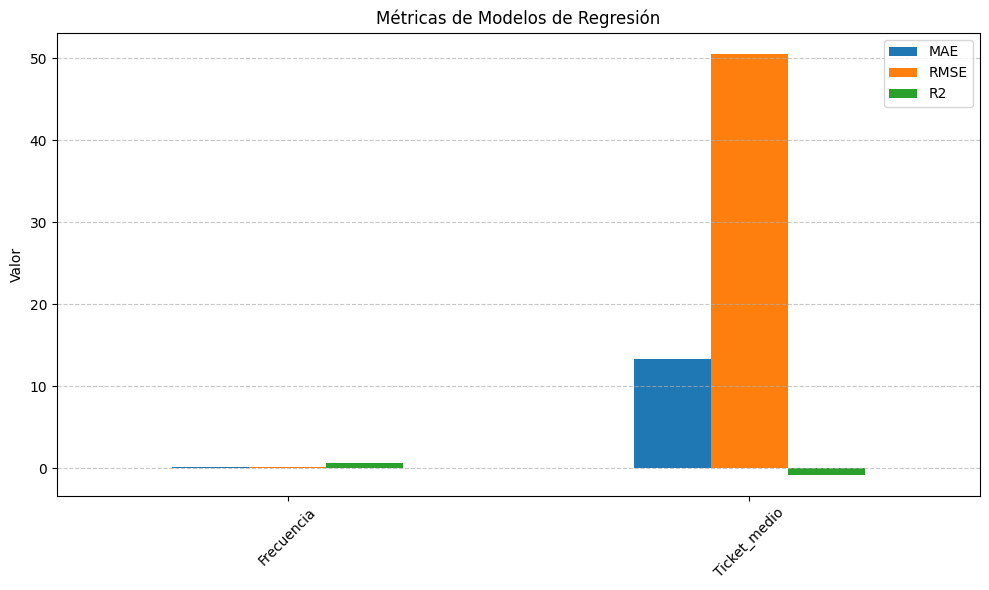

In [192]:
# Crear gráfico de barras
df_regresion.plot(kind='bar', figsize=(10, 6))
plt.title('Métricas de Modelos de Regresión')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [193]:
df_sim

,ID_Cliente,Importe_total_seg,Ticket_medio_seg,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio,campaña,seg_economico_desc,Prediccion_Frecuencia,Prediccion_Ticket_medio
1,C100005,196.48,98.240000,2.163200,110,2024,3,6,2,0,...,0.013865,0.075394,0.2,0.021968,0.353844,1,C03,Ocasionales,2.693728,100.647731
2,C100006,497.88,99.576000,5.616000,254,2024,3,2,3,0,...,0.004074,0.174092,0.0,0.259362,0.395136,1,C05,Dormidos,4.991687,36.973922
3,C100012,423.60,70.600000,5.272800,200,2024,5,4,5,0,...,0.003078,0.137080,0.6,0.712109,0.769607,1,C02,ECI Lovers,5.616200,45.552942
5,C100025,59.16,29.580000,2.163200,81,2024,1,1,2,0,...,0.001612,0.055517,0.4,0.042547,0.357445,0,C04,Estables,3.665029,11.893259
7,C100030,329.46,82.365000,0.899891,112,2024,6,1,2,1,...,0.001109,0.076765,0.4,0.393948,0.418063,0,ninguna,Estables,0.908170,3.434233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131219,C999965,670.29,83.786250,1.462323,19,2024,6,7,5,1,...,0.004840,0.013023,0.6,0.128477,0.672453,0,ninguna,ECI Lovers,1.305068,18.951133
131220,C999966,297.22,148.610000,2.163200,77,2024,3,3,1,1,...,0.012639,0.052776,0.2,-0.314775,0.295365,1,C03,Ocasionales,2.680073,83.307319
131221,C999974,229.99,57.497500,0.674918,189,2024,5,2,3,0,...,0.006197,0.129541,0.0,-0.059644,0.339565,0,ninguna,Dormidos,0.702684,27.350651
131222,C999976,587.35,146.837500,4.326400,103,2024,3,7,3,0,...,0.007439,0.070596,0.4,-0.070695,0.337633,1,C04,Estables,4.569801,61.774210


In [ ]:
campañas = {
    'C01': {'cluster': 'Top Elite'},
    'C02': {'cluster': 'ECI Lovers'},
    'C03': {'cluster': 'Ocasionales'},
    'C04': {'cluster': 'Estables'},
    'C05': {'cluster': 'Dormidos'},
}


df_all = []
for id_campaña, info in campañas.items():
    cluster = info['cluster']

    # Filtramos solo clientes del segmento correspondiente
    idx_segmento = X[X['seg_economico_desc'] == cluster].index
    if len(idx_segmento) == 0:
        continue
    
    X_base = X.loc[idx_segmento].copy()
    
    # Simulamos con y sin campaña
    X_sin = X_base.copy()
    X_sin['campaña'] = 'ninguna'

    

    X_con = X_base.copy()
    X_con['campaña'] = id_campaña

    #Prediccion de frecuencia
    pred_frec_sin = pipelines['Frecuencia'].predict(X_sin)
    pred_frec_con = pipelines['Frecuencia'].predict(X_con)

    #Predicción de ticket medio
    pred_ticket_sin = pipelines['Ticket_medio'].predict(X_sin)
    pred_ticket_con = pipelines['Ticket_medio'].predict(X_con)

    # uplift = pred_con - pred_sin
    # ingreso_esperado = prob_responder * uplift


    # Creamos DataFrame de resultados
    df_tmp = X_base.copy()
    df_tmp['pred_sin_campaña_frec'] = pred_frec_sin
    df_tmp['pred_con_campaña_frec'] = pred_frec_con
    df_tmp['pred_sin_campaña_tick'] = pred_ticket_sin
    df_tmp['pred_con_campaña_tick'] = pred_ticket_con
    df_all.append(df_tmp)
    
    

# Unimos resultados de todas las campañas
df_resultados = pd.concat(df_all).reset_index(drop=True)


In [195]:
df_resultados.head()

,campaña,seg_economico_desc,Edad,Metodo_pago,Canal_preferido,Importe_total,Dias_desde_ultima_factura,Categoria_top,ID_Cliente,Respondio,pred_sin_campaña_frec,pred_con_campaña_frec,pred_sin_campaña_tick,pred_con_campaña_tick
0,C01,Top Elite,18,1,1,70.414740,113,6,C100102,1,1.474154,5.889144,27.958796,49.332010
1,ninguna,Top Elite,24,2,0,89.256389,76,3,C100232,0,1.029651,5.073440,36.452002,61.603201
2,C01,Top Elite,25,2,0,79.619091,122,3,C100242,1,1.080454,5.865247,29.887459,60.193755
3,C01,Top Elite,31,1,1,69.425442,239,0,C100298,0,0.916547,3.908418,29.444936,43.085133
4,C01,Top Elite,64,2,0,109.210740,302,0,C100416,0,0.864953,3.603063,47.730897,99.950184


In [196]:
df_resultados.drop(columns=[
    'pred_sin_campaña_frec',
    'pred_con_campaña_frec',
    'pred_sin_campaña_tick',
    'pred_con_campaña_tick'
], inplace=True)


In [198]:
df_2025 = df_resultados.copy()
 
# Si columna 'Año', actualizamos a 2025
if 'Año' in df_2025.columns:
    df_2025['Año'] = 2025
else:
    df_2025['Año'] = 2025  # Añadir una columna de año si no existe


# ============================
# 2. Predicciones SIN campaña
# ============================
df_2025_sin = df_2025.copy()
X_2025_sin = df_2025_sin[df_2025_sin['campaña'] == 'ninguna']

df_2025.loc[df_2025['campaña'] == 'ninguna', 'Frecuencia_pred_sin'] = pipelines['Frecuencia'].predict(X_2025_sin)
df_2025.loc[df_2025['campaña'] == 'ninguna', 'Ticket_medio_pred_sin'] = pipelines['Ticket_medio'].predict(X_2025_sin)

# ============================
# 3. Predicciones CON campaña por cluster
# ============================

# Mapeo de campañas por cluster económico
campañas = {
    'C01': {'cluster': 'Top Elite',      'impacto': 0.4}, 
    'C02': {'cluster': 'ECI Lovers',     'impacto': 0.3},  
    'C03': {'cluster': 'Ocasionales',    'impacto': 0.2}, 
    'C04': {'cluster': 'Estables',       'impacto': 0.35},   
    'C05': {'cluster': 'Dormidos',       'impacto': 0.25}  
}

df_all_2025 = []

for id_campaña, info in campañas.items():
    cluster = info['cluster']
    impacto = info['impacto']
    
    # Filtrar por cluster económico
    df_cluster = df_2025[df_2025['seg_economico_desc'] == cluster].copy()
    if df_cluster.empty:
        continue

    df_cluster['campaña'] = id_campaña
    df_cluster['Frecuencia_pred_con'] = pipelines['Frecuencia'].predict(df_cluster)
    df_cluster['Ticket_medio_pred_con'] = pipelines['Ticket_medio'].predict(df_cluster)

    # Aplicar uplift estimado
    df_cluster['Frecuencia_pred_con'] *= (1 + impacto)
    df_cluster['Ticket_medio_pred_con'] *= (1 + impacto)

    df_cluster['campaña_asignada'] = id_campaña

    df_all_2025.append(df_cluster)

# Unir todos los clientes con campaña
df_2025_con = pd.concat(df_all_2025).reset_index(drop=True)

# ============================
# 4. Completar con clientes sin campaña asignada
# ============================
clientes_sin_campaña = df_2025.copy()
clientes_sin_campaña['campaña'] = 'Ninguna'
clientes_sin_campaña['Frecuencia_pred_con'] = clientes_sin_campaña['Frecuencia_pred_sin']
clientes_sin_campaña['Ticket_medio_pred_con'] = clientes_sin_campaña['Ticket_medio_pred_sin']
clientes_sin_campaña['Uplift'] = 0
clientes_sin_campaña['Ingreso_esperado'] = 0
clientes_sin_campaña['campaña_asignada'] = 'Ninguna'

df_2025_completo = pd.concat([df_2025_con, clientes_sin_campaña], ignore_index=True)




In [199]:
#vamos a sacar el promedio del ticket medio con y sin campaña
df_2025_completo.describe()

,Edad,Metodo_pago,Canal_preferido,Importe_total,Dias_desde_ultima_factura,Categoria_top,Respondio,Año,Frecuencia_pred_sin,Ticket_medio_pred_sin,Frecuencia_pred_con,Ticket_medio_pred_con,Uplift,Ingreso_esperado
count,137160.000000,137160.000000,137160.000000,137160.000000,137160.000000,137160.000000,137160.000000,137160.0,40000.000000,40000.000000,88580.000000,88580.000000,68580.0,68580.0
mean,43.415092,0.747244,0.237591,94.028443,159.052712,3.930417,0.451619,2025.0,0.873022,23.660505,4.795272,67.477953,0.0,0.0
std,15.024202,0.765574,0.425609,178.368190,103.819640,1.931806,0.497656,0.0,0.284381,64.404781,2.470297,151.331407,0.0,0.0
min,18.000000,0.000000,0.000000,2.276184,0.000000,0.000000,0.000000,2025.0,0.390203,0.915506,0.390203,0.915506,0.0,0.0
25%,30.000000,0.000000,0.000000,32.450625,68.000000,3.000000,0.000000,2025.0,0.628542,9.224162,3.472853,18.596528,0.0,0.0
50%,43.000000,1.000000,0.000000,67.727437,148.000000,3.000000,0.000000,2025.0,0.903934,16.018787,5.711370,43.434193,0.0,0.0
75%,56.000000,1.000000,0.000000,117.674142,244.000000,6.000000,1.000000,2025.0,1.097731,27.945227,6.526262,85.845383,0.0,0.0
max,69.000000,2.000000,1.000000,4837.133775,364.000000,7.000000,1.000000,2025.0,1.921619,1758.041866,13.371295,7303.472231,0.0,0.0


In [103]:
df_2025_completo[df_2025_completo['campaña'] == 'Ninguna'].describe()

,Edad,Importe_total,Dias_desde_ultima_factura,pred_sin_campaña_frec,pred_con_campaña_frec,pred_sin_campaña_tick,pred_con_campaña_tick,Año,Frecuencia_pred_sin,Ticket_medio_pred_sin,Frecuencia_pred_con,Ticket_medio_pred_con,Uplift,Ingreso_esperado
count,68580.000000,68580.000000,68580.000000,68580.000000,68580.000000,68580.000000,68580.000000,68580.0,7749.000000,7749.000000,7749.000000,7749.000000,68580.0,68580.0
mean,43.415092,486.190440,159.052712,-1.455199,5.573324,136.733724,139.569462,2025.0,-2.457687,-49.010338,-2.457687,-49.010338,0.0,0.0
std,15.024257,658.544056,103.820018,0.461017,1.999640,186.631713,183.064350,0.0,0.771519,16.204847,0.771519,16.204847,0.0,0.0
min,18.000000,-819.720000,0.000000,-6.220375,2.040459,-86.151287,-23.102833,2025.0,-6.220375,-86.151287,-6.220375,-86.151287,0.0,0.0
25%,30.000000,229.578900,68.000000,-1.478170,3.886265,82.734677,79.604085,2025.0,-2.664241,-60.961506,-2.664241,-60.961506,0.0,0.0
50%,43.000000,411.588750,148.000000,-1.320000,5.454773,124.140095,117.818642,2025.0,-2.415080,-49.556514,-2.415080,-49.556514,0.0,0.0
75%,56.000000,633.532650,244.000000,-1.241350,7.233059,161.982951,156.519718,2025.0,-1.650000,-37.541683,-1.650000,-37.541683,0.0,0.0
max,69.000000,9903.850200,364.000000,-1.100180,15.703263,3492.878205,3492.878205,2025.0,-1.100180,-4.944005,-1.100180,-4.944005,0.0,0.0


In [161]:


df_2025_completo.to_excel('./Data/Resultados/proyeccion_ventas_2025_v15_nueva.xlsx', index=False)


---

## 4. Gráficos
Vamos a mostrar algunos datos obtenidos mediante gráficos

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

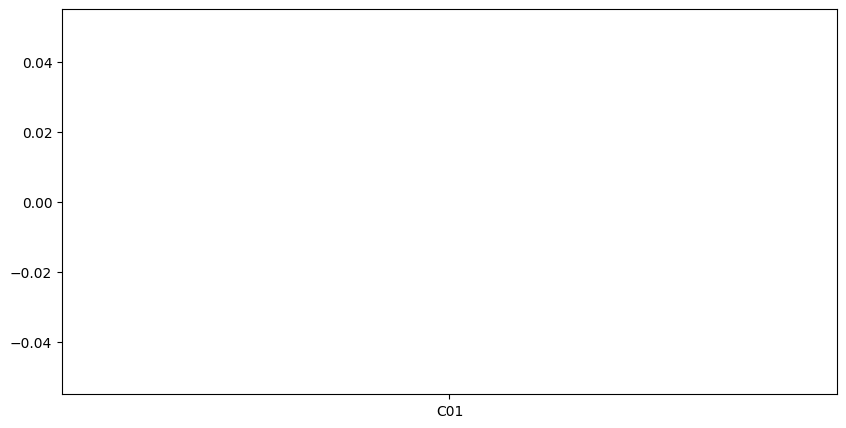

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_2025_completo[df_2025_completo['campaña_asignada'] != 'Ninguna'],
            x='campaña_asignada', y='Uplift', palette='Set2', boxprops=dict(edgecolor='black'))
plt.title('Distribución del Uplift estimado por Campaña')
plt.ylabel('Uplift (€)')
plt.xlabel('Campaña asignada')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


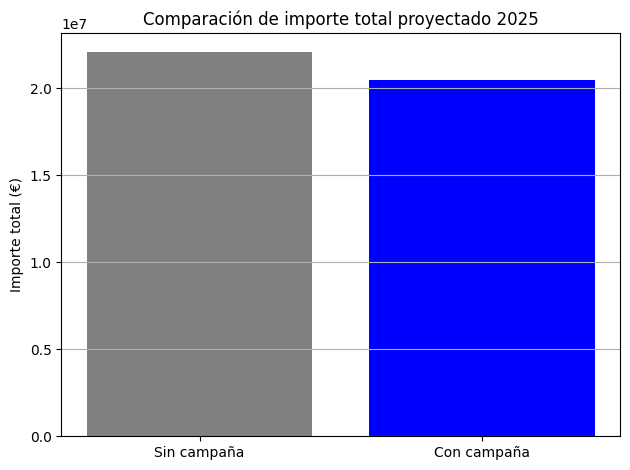

In [88]:
sin_total = df_2025_completo['Ticket_medio_pred_sin'].sum()
con_total = df_2025_completo['Ticket_medio_pred_con'].sum()

plt.bar(['Sin campaña', 'Con campaña'], [sin_total, con_total], color=['gray', 'blue'])
plt.title('Comparación de importe total proyectado 2025')
plt.ylabel('Importe total (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


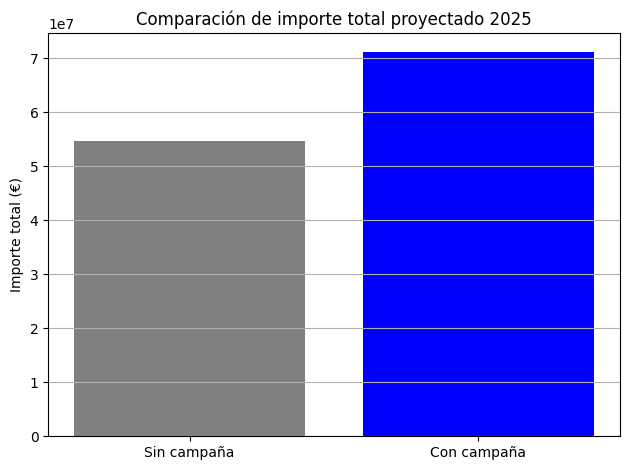

In [ ]:
sin_total = df_2025_completo['Importe_pred_sin'].sum()
con_total = df_2025_completo['Importe_pred_con'].sum()

plt.bar(['Sin campaña', 'Con campaña'], [sin_total, con_total], color=['gray', 'blue'])
plt.title('Comparación de importe total proyectado 2025')
plt.ylabel('Importe total (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [1]:
sin_total = df_2025_completo['Importe_pred_sin'].sum()
con_total = df_2025_completo['Importe_pred_con'].sum()

plt.bar(['Sin campaña', 'Con campaña'], [sin_total, con_total], color=['gray', 'blue'])
plt.title('Comparación de importe total proyectado 2025')
plt.ylabel('Importe total (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


NameError: name 'df_2025_completo' is not defined

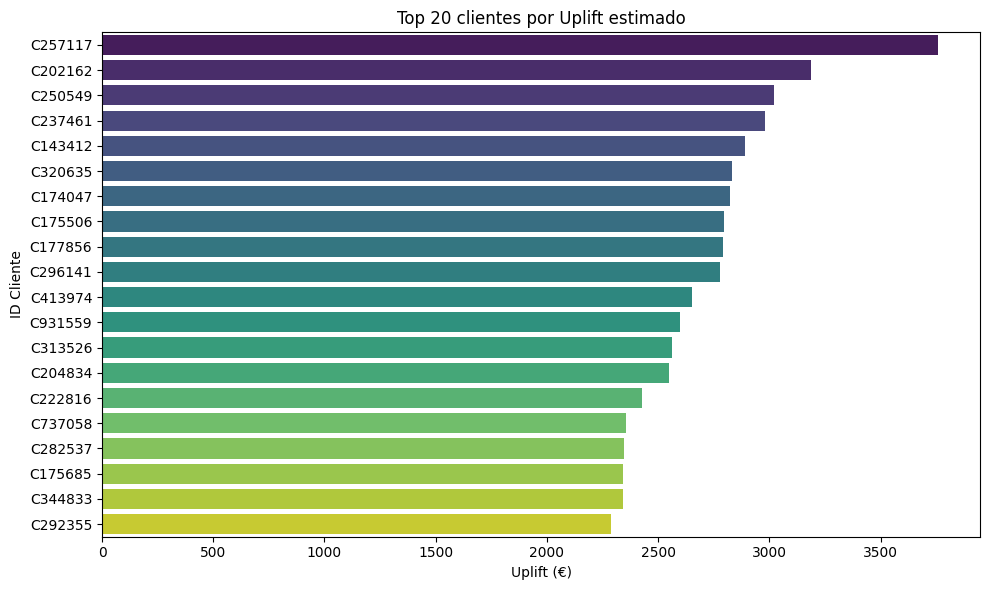

In [352]:
top_uplift = df_2025_completo.sort_values('Uplift', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_uplift, x='Uplift', y='ID_Cliente', palette='viridis')
plt.title('Top 20 clientes por Uplift estimado')
plt.xlabel('Uplift (€)')
plt.ylabel('ID Cliente')
plt.tight_layout()
plt.show()
